---

#### Initialization

---

In [ ]:
%%bash 

## Setup Spark on Colab
pip install -q pyspark
apt-get -qq install -y openjdk-8-jdk-headless

## Setup port-forwarding

# Download ngrok
wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# Unload ngrok
unzip -q ngrok-stable-linux-amd64.zip

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [1]:
import pyspark 
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf, SQLContext 

# Set configuration scope to be local and use port 4050
config_scope = SparkConf().set("spark.ui.port", "4050")

# Create the connection to a Spark cluster
sc = pyspark.SparkContext(conf = config_scope)

# Create a session to programmatically build Spark RDD, DataFrame and DataSet
spark = SparkSession.builder.getOrCreate()

---

### Gathering the Data

---

In [2]:
# -- install if not previously installed in environment
# !pip install matplotlib
# !pip install mapclassify
# !pip install geopandas
# !pip install geoplot
# !pip install pycountry

# -- file operating package
import os

# -- preferred data management packages
import pandas as pd
import numpy as np

# -- preferred plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# -- libraries for geographical plotting functionality
import geopandas
import geoplot
import mapclassify
import pycountry

In [3]:
def read_spark(year):
  '''
  Reads in yearly data using defined options and
  naming convention. Returns None if the year
  does not exist in the looped directory.
  '''
  try:
    return spark.read.option('inferschema', 'true'
    ).option('header', 'true'
    ).csv(f'./drive/MyDrive/STAT 480/Data/{year}weatherdata_updated.csv')
  
  except:
    return None

Grouping data by country to assist in plotting.

In [4]:
def raw_to_grouped(sparkdf_year):
  '''
  Returns spark DataFrame consisting of aggregate
  data by country. See function for more details
  on which aggregations are performed.
  '''
  return spark.createDataFrame(sparkdf_year.groupBy('country name').agg(
    {'temp_ft':'avg',
     'dewpt_ft':'avg',
     'slp_mb':'avg',
     'visib_mi':'avg',
     'wind_knt':'avg',
     'maxwind_knt':'avg',
     'max_gust_knt':'avg',
     'year':'max',
     'month':'max',
     'day':'max',
     'fog':'avg',
     'rain':'avg',
     'snow':'avg',
     'hail':'avg',
     'thunder':'avg',
     'tornado':'avg',
     'precip_in':'avg',
     'max_temp_frnht':'avg',
     'min_temp_frnht':'avg',
     'lat':'avg',
     'lon':'avg',
     'elev(m)':'avg'}).collect())
  
def get_a3(name):
  '''
  Return country's corresponding iso_a3 code. Performed
  for simple merging later on.
  '''
  try:
    return pycountry.countries.get(name=name).alpha_3
  except:
    return 'error'

def convert_grouped_to_plotting(raw_df, world):
  '''
  Transform pyspark.pandas.DataFrame grouped by country name
  into geopandas.GeoDataFrame for plotting purposes.
  '''

  if raw_df == None:
    return None
  
  grouped_df = raw_to_grouped(raw_df)

  grctry_df = grouped_df.select("*").toPandas()
  grctry_df.columns = ['country_name'] + list(map(lambda x: x[x.find('(') + 1 : x.find(')')], grouped_df.columns[1:]))
  grctry_df['country_name'] = grctry_df['country_name'].str.title()
  grctry_df['alpha3'] = grctry_df['country_name'].apply(lambda x: get_a3(x))

  merged_df = pd.merge(
      grctry_df,
      world,
      left_on='alpha3',
      right_on='iso_a3'
  )

  num_stat_df = raw_df.groupBy("country name").agg(countDistinct("station_num")).select("*").toPandas()
  num_stat_df['country_name'] = num_stat_df['country name'].str.title()
  num_stat_df.drop(columns='country name', inplace=True)

  plotting_df = pd.merge(
    geopandas.GeoDataFrame(merged_df),
    num_stat_df,
    on='country_name'
  )
  plotting_df.columns = list(plotting_df.columns[:-1]) + ['num_stations']

  return plotting_df

Before getting into the actual analysis, let's define dataframes and dictionaries that we can use for convenient recollection later on:
- `world` is a `geopandas.GeoDataFrame` containing geographical and plotting-specific information about various countries
- `spark_dict` is a dictionary where the keys are years from 2000 to 2019 and the corresponding values are spark dataframes of data from that year's weather reporting stations
- `plotting_dict` is a dictionary similar to `spark_dict`, except the values also contain plotting specific information of each weather reporting station

In [5]:
# dataframe consisting of country geographical positional and geography shapes
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# creating dictionaries for convenient data recollection in later functions
spark_dict = {year : read_spark(year) for year in range(2000, 2020)}
# plotting_dict = {year:convert_grouped_to_plotting(spark_dict[year], world) for year in range(2000, 2020)}

### Plotting

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_axis_off()
plotting_dict[2008].plot('temp_ft', ax=ax, legend=True, cmap='OrRd',
                 figsize=(15, 10),
                 missing_kwds={'color': 'grey'},
                 legend_kwds={'label': "Avg Daily Temperature (F)",
                        'orientation': "horizontal"})

In [ ]:
df_list = []
for year in plotting_dict.keys():
  if year != 2007:
    df_list.append(plotting_dict[year].groupby(['continent', 'country_name']).agg({
        'snow':'mean',
        'dewpt_ft':'mean',
        'visib_mi':'mean',
        'precip_in':'mean',
        'thunder':'count',
        'fog':'count',
        'min_temp_frnht':'mean',
        'max_gust_knt':'mean',
        'year':'mean',
        'elev(m':'mean',
        'rain':'count',
        'tornado':'count',
        'maxwind_knt':'mean',
        'max_temp_frnht':'mean',
        'lon':'mean',
        'temp_ft':'mean',
        'wind_knt':'mean',
        'hail':'count',
        'slp_mb':'mean',
        'lat':'mean',
        'pop_est':'mean',
        'gdp_md_est':'mean',
        'num_stations':'sum'
    }).reset_index())

by_year = pd.concat(df_list).reset_index(drop=True)

In [ ]:
sns.set_style("whitegrid")
sns.lineplot(x='year', y='num_stations', data=by_year.groupby('year').agg('sum').reset_index(), color='black')
sns.lineplot(x='year', y='num_stations', style='continent', hue='continent', markers=True, data=by_year.groupby(['continent', 'year']).agg('sum').reset_index(), palette='dark')

plt.title('Number of Reporting Stations over Time', weight='bold')
plt.xlabel('Year', weight='bold')
plt.ylabel('# of Stations', weight='bold')
plt.xticks(range(2000,2021,5))
plt.text(2016,6500,"Aggregate", weight='semibold')
plt.legend(bbox_to_anchor=(1,1))

plt.savefig('num_stations_over_time.png', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_axis_off()
plotting_df.plot('num_stations', ax=ax, legend=True, cmap='Greens',
                 figsize=(15, 10),
                 missing_kwds={'color': 'grey'},
                 legend_kwds={'label': "Number of Stations",
                        'orientation': "horizontal"})

In [ ]:
sns.barplot(y='country_name',x='num_stations',data=plotting_df.sort_values('num_stations', ascending=False).head(20),palette='PuBu_r')
# sns.stripplot(y='continent',x='num_stations',data=plotting_df.sort_values('num_stations', ascending=False),palette='Greys')
# sns.boxplot(y='continent',x='num_stations',data=plotting_df.sort_values('num_stations', ascending=False))

---

### **Clustering**

---

talk more here.

In [6]:
cols = ['st', 'temp_ft', 'dewpt_ft', 'slp_mb',
        'wind_knt', 'precip_in', 'max_temp_frnht',
        'min_temp_frnht', 'elev(m)']

df_list = []
for year in spark_dict.keys():
  '''
  Returns spark DataFrame consisting of aggregate
  data by country. See function for more details
  on which aggregations are performed.
  '''
  if spark_dict[year] != None:
    df_list.append(spark.createDataFrame(spark_dict[year].where('ctry == "US"').groupBy(['st', 'year']).agg(
      {'temp_ft':'avg',
      'dewpt_ft':'avg',
      'slp_mb':'avg',
      'wind_knt':'avg',
      'precip_in':'avg',
      'max_temp_frnht':'avg',
      'min_temp_frnht':'avg',
      'lat':'avg',
      'lon':'avg',
      'elev(m)':'avg'}).collect()).toPandas())
    
master_df = pd.concat(df_list).reset_index(drop=True)
master_df.columns = list(map(lambda x: x[x.find('(') + 1 : x.rfind(')')], master_df.columns))
master_df.rename(columns={'s':'state', 'yea':'year'}, inplace=True)

why do we scale?

In [7]:
from sklearn.preprocessing import StandardScaler

nums_df = master_df.drop(columns=['state', 'year', 'lon', 'lat'])

cluster_df = pd.DataFrame(
    StandardScaler().fit_transform(nums_df),
    columns=nums_df.columns
    )
cluster_df['state'] = master_df['state']

In [8]:
nums_df['state'] = master_df['state']
nums_spdf = spark.createDataFrame(nums_df)
cluster_spdf = spark.createDataFrame(cluster_df)

brief explanation here

In [209]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline


numeric_cols = [
  field for (field, dataType) in cluster_spdf.dtypes
  if ((dataType == "double") & (field != "state"))
]

vec_assembler = VectorAssembler(
  inputCols = numeric_cols,
  outputCol = "features"
)

kmeans_model=KMeans(featuresCol='features')

stages = [vec_assembler, kmeans_model]
pipeline = Pipeline(stages=stages)

train_df, test_df = cluster_spdf.randomSplit([.8, .2], seed=480)
train_df = train_df.dropna()
test_df = test_df.dropna()

# Fit k-means model with all recipe steps
pipeline_model = pipeline.fit(train_df)

# Obtain predictions from test data set 
prediction_df = pipeline_model.transform(test_df)
evaluator = ClusteringEvaluator()

# Create ParamGrid for Cross Validation
parameter_grid = ParamGridBuilder() \
  .addGrid(kmeans_model.k, [i for i in range(2,20)])\
  .addGrid(kmeans_model.seed, [480])\
  .addGrid(kmeans_model.maxIter, [1, 5, 10])\
  .build()

# Create a Cross Validation class to perform the multiple
# models required by the parameter gride
cv = CrossValidator(
  estimator = pipeline, 
  estimatorParamMaps = parameter_grid,
  evaluator = evaluator, numFolds = 5)

# Obtain the models
cv_model = cv.fit(train_df)


sleect best params and plot

In [210]:
params = [{p.name: v for p, v in m.items()} for m in cv_model.getEstimatorParamMaps()]
silhouette_scores = pd.DataFrame.from_dict([
    {cv_model.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cv_model.avgMetrics)
]).groupby('k').agg('mean')['silhouette']

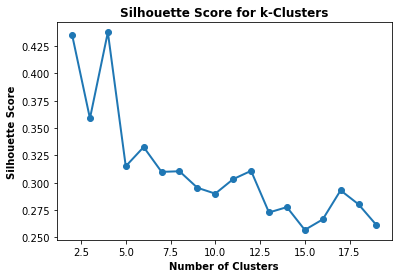

In [219]:
plt.plot(range(2,20), silhouette_scores, linewidth=2, marker='o')
plt.title('Silhouette Score for k-Clusters', weight='bold')
plt.xlabel('Number of Clusters', weight='semibold')
plt.ylabel('Silhouette Score', weight='semibold')
plt.show()

Looks like `k = 2` and `k = 4` clusters provide us with the highest silhouette scores. Although the difference between the two clustering performances are marginal, the difference in interpretability is much larger. With `k = 2` clusters, we are restricting the entire United States to two possible climates which does not seem fitting given the area the country covers. Therefore, we settle for `k = 4` clusters for the increase in interpretability of our results.

In [220]:
# repeat process, this time with k=4 clusters
kmeans_model=KMeans(featuresCol='features', k=4)

stages = [vec_assembler, kmeans_model]
pipeline = Pipeline(stages=stages)

train_df, test_df = cluster_spdf.randomSplit([.8, .2], seed=480)
train_df = train_df.dropna()
test_df = test_df.dropna()

pipeline_model = pipeline.fit(train_df)
prediction_df = pipeline_model.transform(test_df)

Now let's start learning more about each of our clusters. We'll first start with learning how many observations are included in each cluster. Although not observed, some states appear in multiple clusters, so we will account for that later on by assiging each state its mode cluster, and in the case of tie breakers, we will randomly selecting a cluster.

In [221]:
prediction_df.toPandas()['prediction'].value_counts()

0    120
1     34
3     33
2     22
Name: prediction, dtype: int64

Given the distribution of observations across each of the four clusters, let's look into what makes these clusters similar and different from one another. Below, we will perform mergers of our data to allow us to construct specific plots that display various distinctions between the clusters, including differences in standardized attribute levels and geographical location. Reasoning for these clusters will be drawn from intuition.

In [12]:
merged_preds = pd.merge(
    prediction_df.toPandas(),
    cluster_df,
    on=list(cluster_df.columns[:-1])
).drop(columns=['features', 'state_y']).rename(columns={'state_x':'state'})

In [13]:
sns_df = pd.melt(id_vars=['state', 'prediction'], value_vars=['dewpt_ft', 'temp_ft', 'elev(m)', 'wind_knt', 'slp_mb'], frame=merged_preds)

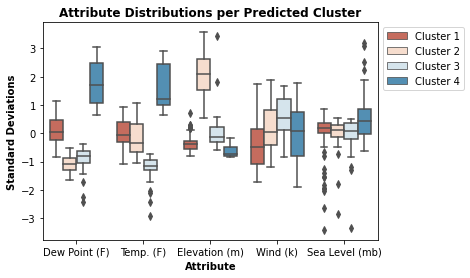

In [207]:
g = sns.boxplot(x='variable', y='value', hue='prediction', palette='RdBu', data=sns_df)
L=plt.legend(bbox_to_anchor=(1,1))
L.get_texts()[0].set_text('Cluster 1')
L.get_texts()[1].set_text('Cluster 2')
L.get_texts()[2].set_text('Cluster 3')
L.get_texts()[3].set_text('Cluster 4')
plt.xlabel('Attribute', weight='semibold')
plt.ylabel('Standard Deviations', weight='semibold')
plt.title('Attribute Distributions per Predicted Cluster', weight='bold')
g.set_xticklabels(['Dew Point (F)', 'Temp. (F)', 'Elevation (m)', 'Wind (k)', 'Sea Level (mb)'])
# plt.savefig('cluster_distinctions.png', bbox_inches='tight')
plt.show()

First off, we notice some stark differences between our clusters in almost every attribute. Considering each of our attributes were standardized before being fit, these results are especially interesting since some clusters do not overlap at all for a given attribute. Most notably, we can define our clusters like such:

| cluster | dew point | temperature | elevation | wind | sea level pressure |
| :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | mid | mid | low | low | mid |
| 2 | low | mid | high | mid | mid |
| 3 | low | low | low | high | mid |
| 4 | high | high | mid | mid | mid |

Knowing that these attributes define the states of each cluster, we can further confirm these similarities and differences by mapping predicted clusters to the corresponding states on a map. Below, we perform a series of `.apply()` functions to gather specific georaphical information and `.merge()` operations to ensure our data is accurately grouped together.

*Note: here we could invert our standardized data to study the original values of each cluster like the table below shows; however, we will not consider the inverted clustering beyond these next few cells.*

In [223]:
s = StandardScaler()
s.fit_transform(nums_df.drop(columns='state'))
inverted_cluster_df = pd.DataFrame(
    s.inverse_transform(prediction_df.toPandas().drop(columns=['state', 'features', 'prediction'])),
    columns=nums_df.columns[:-1])

In [224]:
inverted_cluster_df['prediction'] = prediction_df.toPandas()['prediction']
inverted_cluster_df['state'] = prediction_df.toPandas()['state']

In [225]:
inverted_cluster_df.groupby('prediction').agg('mean')

,dewpt_ft,precip_in,min_temp_frnht,elev(m),max_temp_frnht,temp_ft,wind_knt,slp_mb
prediction,,,,,,,,
0,39.146086,0.068094,39.540287,213.955021,57.746896,48.380042,5.398747,906.570958
1,27.209896,0.033641,35.763969,1377.714562,55.673197,46.621267,6.106944,902.699229
2,28.281592,0.039775,28.921350,465.113484,46.739037,37.330122,6.575357,900.111454
3,55.844234,0.065836,54.258330,108.184344,69.077694,61.814498,5.930047,930.010509


Here we perform a few applications that gather various pieces of information that are not provided in our previous dataframes. These new dataframes require separate libraries, so ensure that they are downloaded before proceeding.

In [226]:
def get_state_name(state_abbr):
  us_divs = sorted(list(pycountry.subdivisions.lookup('US')), key=lambda x: x.name)
  for i, div in enumerate(us_divs):
    if state_abbr == div.code[div.code.find('-') + 1:]:
      return div.name
  return 'MISTAKE'

In [227]:
inverted_cluster_df['state_name'] = inverted_cluster_df['state'].apply(get_state_name)
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

In [228]:
def get_state_geometry(state_name):
  return contiguous_usa[contiguous_usa['state'] == state_name]['geometry'].reset_index(drop=True)

In [229]:
mode_cluster_df = inverted_cluster_df.groupby(['state_name'], as_index=False).agg(pd.Series.mode).rename(columns={'prediction':'pred_mode'})
mode_cluster_df['geometry'] = mode_cluster_df['state_name'].apply(get_state_geometry)
mode_cluster_df.loc[3, 'pred_mode'] = 3     # Arkansas: [0,3]
mode_cluster_df.loc[9, 'pred_mode'] = 3     # Georgia: [0,3]

Now that we have our data prepared, we plot our results to see which clusters contain which states.

In [ ]:
cmaps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r'] 

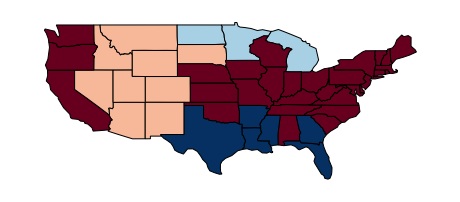

In [230]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import mapclassify as mc


choro_df = mode_cluster_df[~mode_cluster_df['state_name'].isin(['Virgin Islands, U.S.', 'Puerto Rico', 'Alaska', 'Hawaii'])]
gplt.choropleth(geopandas.GeoDataFrame(choro_df), hue='pred_mode', cmap='RdBu')

# for cmap in cmaps:
#   print(f'> {cmap}')
#   gplt.choropleth(geopandas.GeoDataFrame(choro_df), hue='pred_mode', cmap=cmap)
#   plt.show()
#   break

plt.show()